In [85]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from osgeo import gdal
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pyproj

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [86]:
#merge tif files for nightlights 4-5-6
day_04 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_04.csv")
day_05 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_05.csv")
day_06 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_06.csv")

In [87]:
day_04.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,2054340,-81750,2054840,-82250,NaN,NaN,NaN
1,2,2054340,-82250,2054840,-82750,NaN,NaN,NaN
2,3,2054340,-82750,2054840,-83250,NaN,NaN,NaN
3,4,2054340,-83250,2054840,-83750,NaN,NaN,NaN
4,5,2054340,-83750,2054840,-84250,NaN,NaN,NaN


In [88]:
day_04.shape

(131610, 8)

In [5]:
day_04['_mean'].count()

0

In [6]:
day_05['_mean'].count()

20608

In [7]:
day_06['_mean'].count()

14039

In [89]:
# Merge the dataframes on the 'id' column
day_4_6 = pd.merge(day_04, day_05, on='id')
day_4_6 = pd.merge(day_4_6, day_06, on='id')

# Calculate the maximum mean value for each id
day_4_6['max_mean'] = day_4_6[['_mean_x', '_mean_y', '_mean']].max(axis=1)

# Drop the individual 'mean' columns
day_4_6 = day_4_6.drop(['_mean_x', '_mean_y', '_mean'], axis=1)

# Rename the 'max_mean' column to 'mean'
day_4_6 = day_4_6.rename(columns={'max_mean': 'mean'})
day_4_6 = day_4_6[["id","mean"]]

day_4_6.head()

,id,mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [90]:
day_4_6['mean'].count()

30346

In [91]:
wind = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Wind/Isaias_NJ_speed_backwinds_akshay_05302023.csv")
wind.head()

,ID,Center_Latitude,Center_Longitude,Distance,Vmax,Rmax
0,0,41.416894,-74.954401,303.584894,32.247100,120.546311
1,1,41.412650,-74.956148,303.889350,32.248157,120.546311
2,2,41.408405,-74.957895,304.193811,32.249218,120.546311
3,3,41.404161,-74.959642,304.498275,32.313243,120.546311
4,4,41.399917,-74.961389,304.802744,32.314315,120.546311


In [92]:
wind = wind[["ID","Vmax"]]
wind.head()

,ID,Vmax
0,0,32.247100
1,1,32.248157
2,2,32.249218
3,3,32.313243
4,4,32.314315


In [93]:
landcover_zonal = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Landcover/zonal_500.csv")
histo_columns = ['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
                 'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18', 'HISTO_NODATA']

# Convert HISTO columns to percentages
landcover_zonal[histo_columns] = landcover_zonal[histo_columns].div(landcover_zonal[histo_columns].sum(axis=1), axis=0) * 100
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,2,2054340,-82250,2054840,-82750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,3,2054340,-82750,2054840,-83250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,4,2054340,-83250,2054840,-83750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,5,2054340,-83750,2054840,-84250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [94]:
landcover_zonal.shape

(131610, 17)

In [95]:
landcover_zonal.describe()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
count,131610.000000,1.316100e+05,131610.000000,1.316100e+05,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000,131610.000000
mean,65805.500000,2.115590e+06,-215250.000000,2.116090e+06,-215750.000000,0.214279,2.389759,11.657504,3.058500,0.354946,0.388367,12.890164,7.908759,0.244539,19.122997,1.336789,40.433398
std,37992.678801,3.550688e+04,77220.756979,3.550688e+04,77220.756979,3.139494,11.042185,22.794846,9.332954,2.039667,3.188417,24.735643,19.692053,2.852500,31.297314,7.215844,48.668426
min,1.000000,2.054340e+06,-348750.000000,2.054840e+06,-349250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32903.250000,2.084840e+06,-282250.000000,2.085340e+06,-282750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65805.500000,2.115590e+06,-215250.000000,2.116090e+06,-215750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98707.750000,2.146340e+06,-148250.000000,2.146840e+06,-148750.000000,0.000000,0.000000,11.072664,0.000000,0.000000,0.000000,12.867647,0.346021,0.000000,23.529412,0.000000,100.000000
max,131610.000000,2.176840e+06,-81750.000000,2.177340e+06,-82250.000000,100.000000,100.000000,100.000000,96.885813,84.191176,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [96]:
landcover_zonal[landcover_zonal["HISTO_17"]>0].shape

(61240, 17)

In [97]:
rainfall = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Rainfall/Isaias/rainfall_day4.csv")
rainfall.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,41.416894,-74.954401,17.378107
1,1,41.412650,-74.956148,17.378107
2,2,41.408405,-74.957895,17.378107
3,3,41.404161,-74.959642,17.378107
4,4,41.399917,-74.961389,17.378107


In [117]:
rainfall = rainfall.rename(columns={'Unnamed: 0': 'id'})

In [98]:
night_month = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights_Monthly/Zonal_July_Monthly.csv")
night_month.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,2054340,-81750,2054840,-82250,NaN,NaN,NaN
1,2,2054340,-82250,2054840,-82750,NaN,NaN,NaN
2,3,2054340,-82750,2054840,-83250,NaN,NaN,NaN
3,4,2054340,-83250,2054840,-83750,NaN,NaN,NaN
4,5,2054340,-83750,2054840,-84250,NaN,NaN,NaN


In [99]:
night_month.shape

(131610, 8)

In [100]:
night_month['_mean'].count()

80509

In [101]:
night_month = night_month.rename(columns={'_mean': 'nightlight_prev'})
night_month = night_month[["id","nightlight_prev"]]
night_month.head()

,id,nightlight_prev
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [102]:
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,2,2054340,-82250,2054840,-82750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,3,2054340,-82750,2054840,-83250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,4,2054340,-83250,2054840,-83750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,5,2054340,-83750,2054840,-84250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [103]:
wind.head()

,ID,Vmax
0,0,32.247100
1,1,32.248157
2,2,32.249218
3,3,32.313243
4,4,32.314315


In [104]:
day_4_6.head()

,id,mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [105]:
day_4_6=day_4_6.dropna()

In [106]:
day_4_6.shape

(30346, 2)

In [107]:
day_4_6.head()

,id,mean
98,99,1.400000
99,100,1.400000
100,101,0.900000
101,102,5.401564
102,103,8.231423


In [108]:
night_month.head()

,id,nightlight_prev
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [109]:
perc_outage = day_4_6.merge(night_month,on="id")
perc_outage.head()

,id,mean,nightlight_prev
0,99,1.400000,0.662775
1,100,1.400000,0.848879
2,101,0.900000,1.150000
3,102,5.401564,2.905872
4,103,8.231423,3.000000


In [118]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(perc_outage,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,nightlight_prev,outage,Center_Latitude,Center_Longitude,Rainfall
0,99,2054340,-130750,2054840,-131250,0.0,0.0,0.346021,3.114187,0.0,0.0,0.0,0.0,0.0,0.346021,13.840830,82.352941,99.0,35.716262,0.662775,-111.232929,40.996445,-75.125785,43.50561
1,100,2054340,-131250,2054840,-131750,0.0,0.0,41.522491,4.152249,0.0,0.0,0.0,0.0,0.0,8.304498,22.491349,23.529412,100.0,35.810302,0.848879,-64.923410,40.992195,-75.127499,43.50561
2,101,2054340,-131750,2054840,-132250,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,11.764706,101.0,35.812064,1.150000,21.739130,40.987946,-75.129214,43.50561
3,102,2054340,-132250,2054840,-132750,0.0,0.0,39.446367,0.000000,0.0,0.0,0.0,0.0,0.0,13.148789,13.494810,33.910035,102.0,35.813835,2.905872,-85.884441,40.983696,-75.130928,43.50561
4,103,2054340,-132750,2054840,-133250,0.0,0.0,31.833910,7.958478,0.0,0.0,0.0,0.0,0.0,13.494810,12.802768,33.910035,103.0,35.815615,3.000000,-174.380754,40.979446,-75.132641,43.50561


In [119]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_5',
       'HISTO_6', 'HISTO_8', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'HISTO_NODATA', 'ID', 'Vmax', 'nightlight_prev',
       'outage', 'Center_Latitude', 'Center_Longitude', 'Rainfall'],
      dtype='object')

In [120]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID','Center_Latitude',
                                    'Center_Longitude','HISTO_NODATA'], axis=1)
regression_df.shape

(30346, 15)

In [121]:
regression_df.columns

Index(['HISTO_0', 'HISTO_1', 'HISTO_5', 'HISTO_6', 'HISTO_8', 'HISTO_10',
       'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18', 'Vmax',
       'nightlight_prev', 'outage', 'Rainfall'],
      dtype='object')

In [122]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,nightlight_prev,outage,Rainfall
count,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,2.721500e+04,30346.000000
mean,0.583468,6.431723,21.371994,5.861947,0.613578,0.823980,23.702618,9.014054,0.692908,24.690390,2.561153,42.603833,4.340117,-inf,45.735970
std,5.155718,18.598526,29.531540,12.433337,3.126660,5.135586,30.831500,19.639490,5.003373,32.127432,9.298870,5.363201,10.635525,NaN,28.870431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.951416,0.000000,-inf,2.485539
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.978596,0.000009,-7.335185e+01,18.866682
50%,0.000000,0.000000,4.411765,0.000000,0.000000,0.000000,8.088235,0.000000,0.000000,9.191176,0.000000,44.880030,0.842827,-2.053911e+00,44.325710
75%,0.000000,0.000000,35.986159,5.190311,0.000000,0.000000,37.890625,5.536332,0.000000,40.073529,0.000000,46.953988,4.600000,4.377701e+01,71.587420
max,100.000000,100.000000,100.000000,95.955882,84.191176,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,49.790469,442.900000,1.000000e+02,102.050370


### Machine Learning Models

#### Linear Regression

In [123]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,nightlight_prev,outage,Rainfall
count,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,30346.000000,2.721500e+04,30346.000000
mean,0.583468,6.431723,21.371994,5.861947,0.613578,0.823980,23.702618,9.014054,0.692908,24.690390,2.561153,42.603833,4.340117,-inf,45.735970
std,5.155718,18.598526,29.531540,12.433337,3.126660,5.135586,30.831500,19.639490,5.003373,32.127432,9.298870,5.363201,10.635525,NaN,28.870431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.951416,0.000000,-inf,2.485539
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.978596,0.000009,-7.335185e+01,18.866682
50%,0.000000,0.000000,4.411765,0.000000,0.000000,0.000000,8.088235,0.000000,0.000000,9.191176,0.000000,44.880030,0.842827,-2.053911e+00,44.325710
75%,0.000000,0.000000,35.986159,5.190311,0.000000,0.000000,37.890625,5.536332,0.000000,40.073529,0.000000,46.953988,4.600000,4.377701e+01,71.587420
max,100.000000,100.000000,100.000000,95.955882,84.191176,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,49.790469,442.900000,1.000000e+02,102.050370


In [124]:
nan_count = regression_df.isna().sum()
print(nan_count)

HISTO_0               0
HISTO_1               0
HISTO_5               0
HISTO_6               0
HISTO_8               0
HISTO_10              0
HISTO_14              0
HISTO_15              0
HISTO_16              0
HISTO_17              0
HISTO_18              0
Vmax                  0
nightlight_prev       0
outage             3131
Rainfall              0
dtype: int64


In [125]:
perc_outage.head()

,id,outage
0,99,-111.232929
1,100,-64.923410
2,101,21.739130
3,102,-85.884441
4,103,-174.380754


In [126]:
regression_df = regression_df[regression_df["outage"]>0]
regression_df.head()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,nightlight_prev,outage,Rainfall
2,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,35.812064,1.150000,21.739130,43.50561
5,0.0,0.0,45.588235,0.000000,0.0,0.0,0.0,0.0,0.0,16.544118,7.720588,35.910607,4.836946,48.314491,43.50561
6,0.0,0.0,1.384083,0.000000,0.0,0.0,0.0,0.0,0.0,4.498270,7.958478,35.912407,6.500000,61.538462,43.50561
7,0.0,0.0,8.203125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,23.437500,35.738656,0.853225,26.937532,43.50561
9,0.0,0.0,92.647059,7.352941,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,35.834563,0.760320,73.364825,43.50561


In [127]:
df = regression_df.copy()

#df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('outage', axis=1)  # Independent variables
y = df['outage']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : 1.7074016004658967
HISTO_1 : -1.6741316978366294
HISTO_5 : 6.69879821616676
HISTO_6 : 0.26538886266388373
HISTO_8 : -0.7970310821379021
HISTO_10 : -0.3971835118943938
HISTO_14 : 2.0781384599557557
HISTO_15 : 2.504813531879325
HISTO_16 : -0.33126165267699953
HISTO_17 : -7.7839296094778
HISTO_18 : 2.3955841948974532
Vmax : -8.18796432827045
nightlight_prev : -0.48801614164460605
Rainfall : -0.0292016322877231
R2 score on the test set: 0.2991427884474903


#### Poisson Regression

In [128]:
import statsmodels.api as sm
import pandas as pd

# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = 'outage'
independent_vars = [col for col in df.columns if col != target]

# Fit the Poisson GLM
X = df[independent_vars]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df[target]

poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the model
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 outage   No. Observations:                13160
Model:                            GLM   Df Residuals:                    13145
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5643e+05
Date:                Wed, 14 Jun 2023   Deviance:                   2.4147e+05
Time:                        10:19:30   Pearson chi2:                 2.13e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9991
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.2820      0.017    3

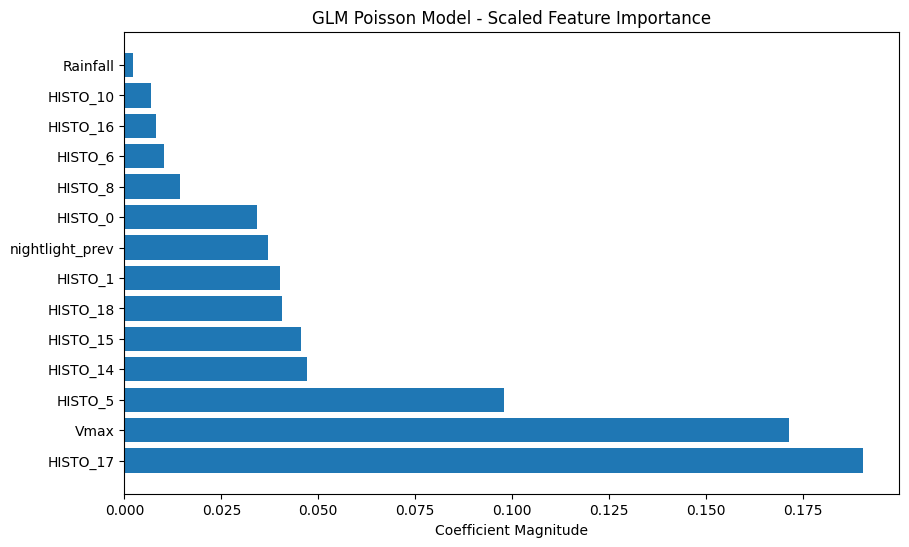

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a pandas DataFrame called 'data'
# X should contain the features used in your model
X = df[independent_vars]
y = df[target]

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a GLM Poisson model on the scaled data
glm_model = sm.GLM(y, sm.add_constant(X_scaled), family=sm.families.Poisson()).fit()

# Get the absolute values of the coefficients
coef_abs = np.abs(glm_model.params[1:])

# Sort the coefficients in descending order
sorted_indices = np.argsort(coef_abs)[::-1]
sorted_coef_abs = coef_abs[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = X.columns[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coef_abs)), sorted_coef_abs, align='center')
plt.yticks(range(len(sorted_coef_abs)), sorted_feature_names)
plt.xlabel('Coefficient Magnitude')
plt.title('GLM Poisson Model - Scaled Feature Importance')
plt.show()

In [136]:
df.head()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,nightlight_prev,outage,Rainfall
2,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,35.812064,1.150000,21.739130,43.50561
5,0.0,0.0,45.588235,0.000000,0.0,0.0,0.0,0.0,0.0,16.544118,7.720588,35.910607,4.836946,48.314491,43.50561
6,0.0,0.0,1.384083,0.000000,0.0,0.0,0.0,0.0,0.0,4.498270,7.958478,35.912407,6.500000,61.538462,43.50561
7,0.0,0.0,8.203125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,23.437500,35.738656,0.853225,26.937532,43.50561
9,0.0,0.0,92.647059,7.352941,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,35.834563,0.760320,73.364825,43.50561


In [138]:
import pandas as pd
import statsmodels.api as sm

# Assuming your dataframe is named 'df'
# X represents the independent variables, and 'outage' is the target variable
X = df.drop(['outage'], axis=1)
y = df['outage']

# Fit negative binomial regression model
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()

# Predict the target variable
y_pred = nb_results.predict(X)

# Calculate mean squared error
mse = ((y - y_pred) ** 2).mean()
print("Mean Squared Error (MSE):", mse)

c:\Users\omhai\anaconda3\envs\gdalpip\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Mean Squared Error (MSE): 1288.5737959220412


In [142]:
# Print the model summary
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 outage   No. Observations:                13160
Model:                            GLM   Df Residuals:                    13146
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65321.
Date:                Wed, 14 Jun 2023   Deviance:                       9435.6
Time:                        10:35:48   Pearson chi2:                 8.62e+03
No. Iterations:                    55   Pseudo R-squ. (CS):           -0.01586
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
HISTO_0             0.0107      0.002     

In [141]:
#pip install seaborn

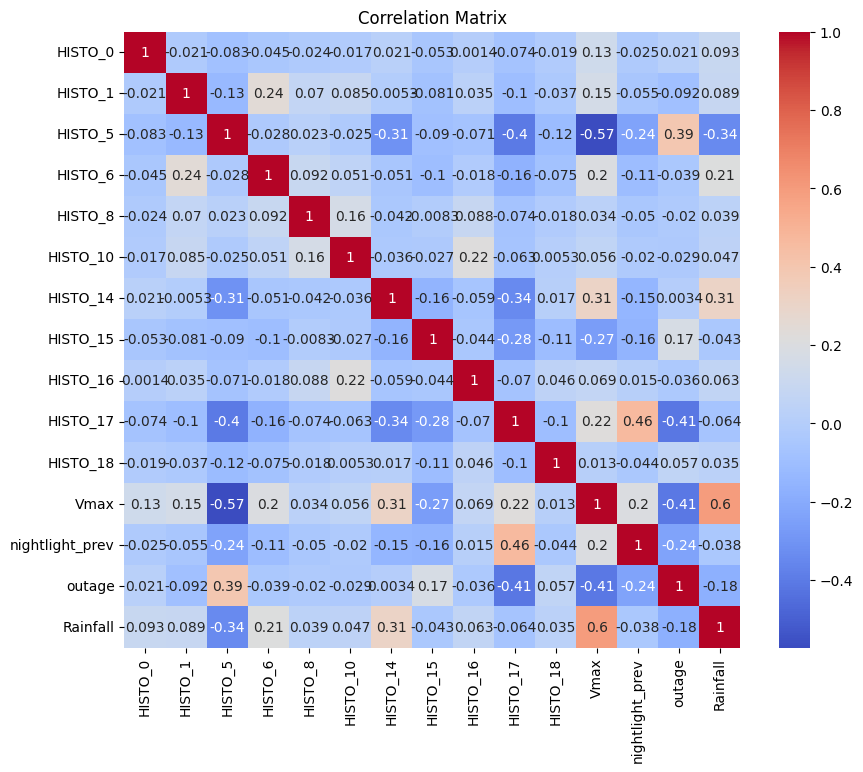

In [134]:
# check correlation between variables
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [139]:
df.head()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,nightlight_prev,outage,Rainfall
2,0.0,0.0,67.279412,0.000000,0.0,0.0,0.0,0.0,0.0,7.352941,13.602941,35.812064,1.150000,21.739130,43.50561
5,0.0,0.0,45.588235,0.000000,0.0,0.0,0.0,0.0,0.0,16.544118,7.720588,35.910607,4.836946,48.314491,43.50561
6,0.0,0.0,1.384083,0.000000,0.0,0.0,0.0,0.0,0.0,4.498270,7.958478,35.912407,6.500000,61.538462,43.50561
7,0.0,0.0,8.203125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,23.437500,35.738656,0.853225,26.937532,43.50561
9,0.0,0.0,92.647059,7.352941,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,35.834563,0.760320,73.364825,43.50561


In [140]:
df.to_csv("reg_out.csv")

In [83]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(day_4_6,how="inner",on="id")
regression_df = regression_df.merge(df2,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,mean,outage,Center_Latitude,Center_Longitude,Rainfall
0,633,2054840,-130250,2055340,-130750,0.0,0.0,8.203125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,23.437500,68.359375,633.0,35.738656,0.623387,10.944658,40.999349,-75.118316,43.50561
1,634,2054840,-130750,2055340,-131250,0.0,0.0,58.088235,8.823529,0.0,0.0,0.0,0.0,0.0,11.764706,17.279412,4.044118,634.0,35.740453,0.668441,10.874580,40.995100,-75.120032,43.50561
2,635,2054840,-131250,2055340,-131750,0.0,0.0,92.647059,7.352941,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,635.0,35.834563,0.202513,75.024560,40.990850,-75.121747,43.50561
3,637,2054840,-132250,2055340,-132750,0.0,0.0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,637.0,35.838205,1.050000,8.695652,40.982351,-75.125176,43.50561
4,638,2054840,-132750,2055340,-133250,0.0,0.0,91.176471,0.000000,0.0,0.0,0.0,0.0,0.0,8.823529,0.000000,0.000000,638.0,35.840040,0.591641,45.972662,40.978101,-75.126890,43.50561


In [84]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_5',
       'HISTO_6', 'HISTO_8', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'HISTO_NODATA', 'ID', 'Vmax', 'mean', 'outage',
       'Center_Latitude', 'Center_Longitude', 'Rainfall'],
      dtype='object')

In [ ]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID','Center_Latitude',
                                    'Center_Longitude','HISTO_NODATA'], axis=1)
regression_df.shape

In [ ]:
df = regression_df.copy()

#df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('mean', axis=1)  # Independent variables
y = df['mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

### Recovery

In [39]:
day_01 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights_Monthly/Zonal_Day_01.csv")
day_01 = day_01[["id","_mean"]]

In [40]:
day_4_6.head()

,id,mean
98,99,1.400000
99,100,1.400000
100,101,0.900000
101,102,5.401564
102,103,8.231423


In [74]:
df2 = day_01.merge(day_4_6,on="id",how="inner")
df2.head()

,id,_mean,mean
0,99,0.800000,1.400000
1,100,0.843006,1.400000
2,101,0.900000,0.900000
3,102,1.244677,5.401564
4,103,1.050000,8.231423


In [75]:
df2.shape

(30346, 3)

In [76]:
df2["outage"] = (df2["_mean"] - df2["mean"])/df2["_mean"]*100
df2.head()
df2 = df2[["id","outage"]]
df2.head()

,id,outage
0,99,-75.000000
1,100,-66.072387
2,101,0.000000
3,102,-333.973120
4,103,-683.945011


In [77]:
df2.shape

(30346, 2)

In [78]:
df2 = df2[df2["outage"]>0]
df2.shape

(17369, 2)

In [79]:
df2.head()

,id,outage
7,633,10.944658
8,634,10.874580
9,635,75.024560
11,637,8.695652
12,638,45.972662


In [82]:
df2["outage"].min()

0.001430053286885502

In [80]:
df2.to_csv("out.csv")

In [46]:
#merge tif files for nightlights 4-5-6
day_07 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_07.csv")
day_08 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_08.csv")
day_09 = pd.read_csv("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Zonal_Day_09.csv")

# Merge the dataframes on the 'id' column
day_7_9 = pd.merge(day_07, day_08, on='id')
day_7_9 = pd.merge(day_7_9, day_09, on='id')

# Calculate the maximum mean value for each id
day_7_9['max_mean'] = day_7_9[['_mean_x', '_mean_y', '_mean']].max(axis=1)

# Drop the individual 'mean' columns
day_7_9 = day_7_9.drop(['_mean_x', '_mean_y', '_mean'], axis=1)

# Rename the 'max_mean' column to 'mean'
day_7_9 = day_7_9.rename(columns={'max_mean': 'phase2'})
day_7_9 = day_7_9[["id","phase2"]]

day_7_9.head()

,id,phase2
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [47]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(df2,how="inner",on="id")
regression_df = regression_df.merge(day_7_9,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,outage,phase2,nightlight_prev,Center_Latitude,Center_Longitude,Rainfall
0,633,2054840,-130250,2055340,-130750,0.0,0.0,8.203125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,23.437500,68.359375,633.0,35.738656,10.944658,1.200000,0.853225,40.999349,-75.118316,43.50561
1,634,2054840,-130750,2055340,-131250,0.0,0.0,58.088235,8.823529,0.0,0.0,0.0,0.0,0.0,11.764706,17.279412,4.044118,634.0,35.740453,10.874580,0.750000,0.600000,40.995100,-75.120032,43.50561
2,635,2054840,-131250,2055340,-131750,0.0,0.0,92.647059,7.352941,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,635.0,35.834563,75.024560,0.768198,0.760320,40.990850,-75.121747,43.50561
3,637,2054840,-132250,2055340,-132750,0.0,0.0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,637.0,35.838205,8.695652,1.050000,1.050000,40.982351,-75.125176,43.50561
4,638,2054840,-132750,2055340,-133250,0.0,0.0,91.176471,0.000000,0.0,0.0,0.0,0.0,0.0,8.823529,0.000000,0.000000,638.0,35.840040,45.972662,1.296287,1.347842,40.978101,-75.126890,43.50561


In [48]:
regression_df = regression_df.dropna(subset=['nightlight_prev'])
regression_df.shape

(17369, 25)

In [49]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_5',
       'HISTO_6', 'HISTO_8', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'HISTO_NODATA', 'ID', 'Vmax', 'outage',
       'phase2', 'nightlight_prev', 'Center_Latitude', 'Center_Longitude',
       'Rainfall'],
      dtype='object')

In [50]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID',"Center_Latitude",
                                    "Center_Longitude"], axis=1)
regression_df.shape

(17369, 17)

In [51]:
regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(12243, 17)

In [52]:
regression_df = regression_df.dropna(subset=['phase2'])
regression_df.shape

(12036, 17)

In [53]:
df = regression_df.copy()

df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('phase2', axis=1)  # Independent variables
y = df['phase2']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : -0.007515994776895166
HISTO_1 : -0.13478056783169357
HISTO_5 : -0.18861922736961678
HISTO_6 : -0.1359679141295948
HISTO_8 : -0.046115635851143436
HISTO_10 : -0.01296777560932677
HISTO_14 : -0.14885244747796894
HISTO_15 : -0.19158734113200113
HISTO_16 : -0.06325606578997597
HISTO_17 : -0.26658398470793243
HISTO_18 : -0.010962904639062396
Vmax : 0.21219472863273714
outage : 0.0003456781210194326
nightlight_prev : 9.014479246119022
Rainfall : -0.023651770727862287
R2 score on the test set: 0.9231610592673607


In [56]:
df.head()

,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,outage,phase2,nightlight_prev,Rainfall
1,0.0,0.0,58.088235,8.823529,0.0,0.0,0.0,0.0,0.0,11.764706,17.279412,35.740453,10.874580,0.750000,0.600000,43.505610
4,0.0,0.0,91.176471,0.000000,0.0,0.0,0.0,0.0,0.0,8.823529,0.000000,35.840040,45.972662,1.296287,1.347842,43.505610
5,0.0,0.0,78.546713,21.107266,0.0,0.0,0.0,0.0,0.0,0.346021,0.000000,35.764598,24.797900,0.490752,0.586430,43.505610
10,0.0,0.0,61.591696,30.103806,0.0,0.0,0.0,0.0,0.0,4.844291,3.460208,35.693463,39.000947,1.200000,0.750000,16.983023
17,0.0,0.0,76.838235,17.647059,0.0,0.0,0.0,0.0,0.0,4.779412,0.735294,35.890707,27.490127,1.804965,1.435748,43.505610


In [62]:
sorted_df = df2.sort_values('outage', ascending=False)
sorted_df.head()

,id,outage
11431,54072,100.0
4462,23557,100.0
4533,23633,100.0
4532,23632,100.0
4531,23631,100.0


In [59]:
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,2054340,-81750,2054840,-82250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,2,2054340,-82250,2054840,-82750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,3,2054340,-82750,2054840,-83250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,4,2054340,-83250,2054840,-83750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,5,2054340,-83750,2054840,-84250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [63]:
sorted_df = sorted_df.merge(landcover_zonal,left_on="id",right_on="id")
sorted_df.head()

,id,outage,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,54072,100.0,2104840,-99750,2105340,-100250,0.0,2.768166,43.598616,30.449827,0.0,0.0,23.183391,0.000000,0.0,0.000000,0.0,0.0
1,23557,100.0,2076340,-89750,2076840,-90250,0.0,0.000000,68.750000,0.000000,0.0,0.0,31.250000,0.000000,0.0,0.000000,0.0,0.0
2,23633,100.0,2076340,-127750,2076840,-128250,0.0,0.000000,21.799308,2.076125,0.0,0.0,23.529412,42.560554,0.0,10.034602,0.0,0.0
3,23632,100.0,2076340,-127250,2076840,-127750,0.0,0.000000,16.544118,5.147059,0.0,0.0,4.044118,74.264706,0.0,0.000000,0.0,0.0
4,23631,100.0,2076340,-126750,2076840,-127250,0.0,0.000000,63.667820,5.536332,0.0,0.0,2.422145,15.570934,0.0,12.802768,0.0,0.0


In [ ]:
sorted

In [64]:
sorted_df.shape

(17369, 18)

In [65]:
sorted_df = sorted_df[sorted_df["HISTO_17"]>0]
sorted_df.shape

(12243, 18)

In [66]:
sorted_df.head()

,id,outage,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_5,HISTO_6,HISTO_8,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
2,23633,100.0,2076340,-127750,2076840,-128250,0.0,0.0,21.799308,2.076125,0.0,0.000000,23.529412,42.560554,0.0,10.034602,0.000000,0.0
4,23631,100.0,2076340,-126750,2076840,-127250,0.0,0.0,63.667820,5.536332,0.0,0.000000,2.422145,15.570934,0.0,12.802768,0.000000,0.0
5,23630,100.0,2076340,-126250,2076840,-126750,0.0,0.0,97.923875,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.076125,0.000000,0.0
9,23626,100.0,2076340,-124250,2076840,-124750,0.0,0.0,73.529412,0.000000,0.0,0.000000,6.617647,11.397059,0.0,8.455882,0.000000,0.0
11,23624,100.0,2076340,-123250,2076840,-123750,0.0,0.0,37.370242,24.567474,0.0,1.038062,10.034602,16.608997,0.0,9.342561,1.038062,0.0


In [70]:
sorted_df.to_csv("outages.csv")

In [67]:
sorted_df["id"]

2         23633
4         23631
5         23630
9         23626
11        23624
12        23623
13        48179
14        48180
15        48181
16        48182
17        48183
18        23614
19        48184
20        48185
22        23635
24        23650
25        23661
27        23659
28        47736
29        23656
30        23655
31        23652
32        23651
34        23638
40        48177
41        23641
42        23640
43        48186
44        23603
45        48187
46        23568
52        23571
53        23570
54        23569
55        23567
56        23578
60        23563
61        23562
65        23577
66        23579
67        48188
69        23599
71        23597
72        23596
73        23595
74        23594
78        23580
79        48189
80        23587
81        23586
82        23585
84        23583
85        23582
86        23581
87        23662
91        24122
93        24119
94        24118
95        24117
96        24116
97        24115
99        24112
100     

In [69]:
id_list = sorted_df['id'].tolist()

id_list

[23633,
 23631,
 23630,
 23626,
 23624,
 23623,
 48179,
 48180,
 48181,
 48182,
 48183,
 23614,
 48184,
 48185,
 23635,
 23650,
 23661,
 23659,
 47736,
 23656,
 23655,
 23652,
 23651,
 23638,
 48177,
 23641,
 23640,
 48186,
 23603,
 48187,
 23568,
 23571,
 23570,
 23569,
 23567,
 23578,
 23563,
 23562,
 23577,
 23579,
 48188,
 23599,
 23597,
 23596,
 23595,
 23594,
 23580,
 48189,
 23587,
 23586,
 23585,
 23583,
 23582,
 23581,
 23662,
 24122,
 24119,
 24118,
 24117,
 24116,
 24115,
 24112,
 24124,
 24105,
 24123,
 24125,
 24102,
 24136,
 47650,
 47651,
 47652,
 24139,
 24138,
 24135,
 24134,
 24133,
 24132,
 24131,
 24130,
 24129,
 24128,
 24101,
 23733,
 47657,
 47658,
 47659,
 47675,
 24079,
 47676,
 23737,
 23734,
 24080,
 24099,
 24098,
 24081,
 24087,
 24086,
 24084,
 24083,
 24082,
 22553,
 23027,
 23017,
 23016,
 23014,
 23013,
 23010,
 23051,
 23050,
 48724,
 23047,
 23046,
 23045,
 23036,
 23035,
 23034,
 48725,
 48726,
 22566,
 22574,
 22573,
 22571,
 22570,
 22565,
 22564,


In [71]:
gdf = gpd.read_file("C:/Users/omhai/OneDrive/Desktop/Shetty/Capstone Project/Nightlights/Isaias/Grid_500_NJ.shp")
gdf.head()

,id,left,top,right,bottom,geometry
0,1.0,2054340.0,-81750.0,2054840.0,-82250.0,"POLYGON ((2054340.000 -81750.000, 2054840.000 ..."
1,2.0,2054340.0,-82250.0,2054840.0,-82750.0,"POLYGON ((2054340.000 -82250.000, 2054840.000 ..."
2,3.0,2054340.0,-82750.0,2054840.0,-83250.0,"POLYGON ((2054340.000 -82750.000, 2054840.000 ..."
3,4.0,2054340.0,-83250.0,2054840.0,-83750.0,"POLYGON ((2054340.000 -83250.000, 2054840.000 ..."
4,5.0,2054340.0,-83750.0,2054840.0,-84250.0,"POLYGON ((2054340.000 -83750.000, 2054840.000 ..."


In [72]:
gdf['id'] = gdf['id'].astype(int)
gdf.head()

,id,left,top,right,bottom,geometry
0,1,2054340.0,-81750.0,2054840.0,-82250.0,"POLYGON ((2054340.000 -81750.000, 2054840.000 ..."
1,2,2054340.0,-82250.0,2054840.0,-82750.0,"POLYGON ((2054340.000 -82250.000, 2054840.000 ..."
2,3,2054340.0,-82750.0,2054840.0,-83250.0,"POLYGON ((2054340.000 -82750.000, 2054840.000 ..."
3,4,2054340.0,-83250.0,2054840.0,-83750.0,"POLYGON ((2054340.000 -83250.000, 2054840.000 ..."
4,5,2054340.0,-83750.0,2054840.0,-84250.0,"POLYGON ((2054340.000 -83750.000, 2054840.000 ..."


In [73]:
gdf.to_file("grid_nj.shp")